### Text Selection Data Prepare

This notebook was used for data pre-processing in the text selection project.

In [1]:
import os
import multiprocessing
#import multiprocessing as mp
from multiprocessing import Process, Manager, Pool, Queue
from itertools import islice
from collections import Counter
import re
import pandas as pd
import numpy as np
import glob
import nltk
from nltk import word_tokenize
from functools import reduce
from pathlib import Path
import shutil
from kneed import KneeLocator

In [2]:
nprocs = multiprocessing.cpu_count()
print(f"Number of CPU cores: {nprocs}")

Number of CPU cores: 16


In [3]:
# language pair
lang_folder = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
#lang_pair = "Intersect"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# adding native word to shared word
word_start = 0  # 0 native word start index
word_end = 45000  # 28 native word end index

# word all usage in twogram
word_use_num_min = 1  # word usage in selected twograms 
word_use_num_max = 2

# sentence check
twogram_sentence_check = False  # True, False
threegram_sentence_check = False
fourgram_sentence_check = False
fivegram_sentence_check = False
sixgram_sentence_check = False
sevengram_sentence_check = False
eightgram_sentence_check = False
ninegram_sentence_check = False
tengram_sentence_check = False


# n gram select
twogram_select_start = 0
twogram_select_end = 10000

threegram_select_start = 0
threegram_select_end = 10000

fourgram_select_start = 0
fourgram_select_end = 10000

fivegram_select_start = 0
fivegram_select_end = 10000

sixgram_select_start = 0
sixgram_select_end = 10000

sevengram_select_start = 0
sevengram_select_end = 10000

eightgram_select_start = 0
eightgram_select_end = 10000

ninegram_select_start = 0
ninegram_select_end = 10000

tengram_select_start = 0
tengram_select_end = 10000


# prefix suffix file
prefix_suffix = False  # True, False: True for adding prefix suffix word
native_word = True # True for adding native word

# adding output file extention
if prefix_suffix & native_word:
    file_ext = "5"
elif (not prefix_suffix) & native_word:
    file_ext = "6"
else:
    file_ext = "7"              
    
# 5 => for only native word with prefix suffix.
# 6 => for only native word without prefix suffix.

print(f"{file_ext}")

6


In [4]:
path = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/\
Text Selection/Data/1-Text Selection Data Prepare"

Path(path).mkdir(parents=True, exist_ok=True)

In [5]:
def strip(df):
    for i in df.columns:
        new_name = i.strip()
        df.rename(columns={f"{i}":f"{new_name}"}, inplace=True)
        df[f"{new_name}"] = df[f"{new_name}"].apply(lambda x: x.strip())
    
    return df

In [6]:
def word_in_wordgroup_simple(df, source_column, target_column, word_sample_num):

    '''word_in_wordgroup(df, "word", "twogram"):
       df is dataframe, source_column and target_column are 
       dataframe column string name. source_column convert list
       values that are in target column.
    '''
    
    df_select = df[[f"{target_column}"]].dropna()
    df_result = pd.DataFrame()
    for i in df[f"{source_column}"].dropna():
        try:
            word_in_word_cluster = df_select[df_select[f"{target_column}"].str.contains(fr"(?:\s|^){i}(?:\s|$)", na=False)].head(word_sample_num)    
        except:
            pass        
        word_in_word_cluster.insert(0,f"{source_column}",i)
        df_result = pd.concat([df_result,word_in_word_cluster], axis=0)
    df_result.reset_index(drop=True, inplace=True)

    return df_result

In [7]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,you,102069964
1,i,94447074
2,the,77481215
3,to,58281119
4,is,50852895
...,...,...
552149,fruitcocktail,6
552150,andthesunlightshining,6
552151,upravo,6
552152,yagawa,6


In [8]:
df_word_select = df_word_all.iloc[word_start:word_end,]

In [9]:
# Option
if prefix_suffix:
    df_word = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()}/{lang_folder.capitalize()}_{word_end}_Word_Prefix_Suffix_Custom_Result_Manuel.xlsx")
    df_word = df_word.loc[:,["word","frequency"]]
    df_word = pd.concat([df_word,df_word_select], axis=0)
    df_word.drop_duplicates(inplace=True)    
    df_word.sort_values(by="frequency", ascending=False, inplace=True)
    df_word.reset_index(drop=True, inplace=True)
else:
    df_word = df_word_select

if native_word:
    df_word
else:
    df_word = df_word.head(0)

df_word

,word,frequency
0,you,102069964
1,i,94447074
2,the,77481215
3,to,58281119
4,is,50852895
...,...,...
44995,pythons,630
44996,bubbe,630
44997,clucking,630
44998,komal,630


In [10]:
df_word.to_excel(f"Word_Selected_{word_end}.xlsx", index=False)

In [11]:
disable_list = ["sex","seks","seksi","sexy","sexe","seksüel","sexuell","gey","gay","lezbiyen","lesbienne","eşcinsel","mastürbasyon","masturbation","erotik","érotique", \
"bikini","penis","vagina","vajina","fetish","fetiş","fetishy","erotic","erotik","sexdom","kondom","condom","dildo","fetisj","hétérosexuel","féticher","fétiche","homosexuel"\
"ereksiyon","erectie","erection","érection","homoseksüel","prezervatif","préservatif","ass","fetisch","fetiche"]

In [12]:
word_select = df_word["word"].values.tolist()
word_select_set = set(word_select)
disable_word_set = set(disable_list)

In [13]:
word_list = list(word_select_set.difference(disable_word_set))
len(word_list)

44918

##### Ngrams Selected

In [14]:
if twogram_sentence_check:
    df_twogram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Two_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_twogram_sent.rename(columns={"two_gram":"twogram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_twogram = df_twogram_sent.loc[:,["twogram","frequency"]]
    #df_twogram_select = df_twogram.iloc[twogram_start:twogram_end,]
else:
    df_twogram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Twogram_Merge.csv")  
    df_twogram = df_twogram.loc[:,["twogram","frequency"]]
    #df_twogram_select = df_twogram.iloc[twogram_start:twogram_end,]

df_twogram = df_twogram[df_twogram["frequency"] > 5]
df_twogram

,twogram,frequency
0,i am,9310563
1,do not,8095395
2,it s,7436197
3,that s,4564126
4,you re,4355237
...,...,...
4505226,hoof taps,6
4505227,benjamin wells,6
4505228,run title,6
4505229,router back,6


In [15]:
d_list2  = df_twogram.iloc[:,0].values.tolist()

resultlist2 = []
manager = multiprocessing.Manager()
resultlist2 = manager.list()

def wordgroup_with_words(d_list2):
    mergelist = []
    try:
        word = d_list2.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist2.append(d_list2)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list2) # string_word liste

result_list2 = list(resultlist2)
df_result2 = pd.DataFrame(result_list2, columns=[0])  # add columns parameter for empty result
df_result2 = df_result2.rename(columns = {0: "twogram"})
df_merge2 = pd.merge(df_result2, df_twogram, how="left", on="twogram")
df_merge_result2 = df_merge2.sort_values(by="frequency", ascending=False)
df_merge_result2.drop_duplicates(inplace=True)
df_merge_result2.reset_index(drop=True, inplace=True)
df_twogram_select = df_merge_result2
df_twogram_select

,twogram,frequency
0,i am,9310563
1,do not,8095395
2,it s,7436197
3,that s,4564126
4,you re,4355237
...,...,...
3630143,train honey,6
3630144,go blackwater,6
3630145,hammond suggested,6
3630146,jano would,6


In [16]:
twogram_frequency = df_twogram_select.iloc[:,1].sum()

In [17]:
df_twogram_select["ratio"] = round(((df_twogram_select.iloc[:,1]/twogram_frequency)*100),7)

In [18]:
df_twogram_select["cumul_ratio"] = np.cumsum(df_twogram_select["ratio"])

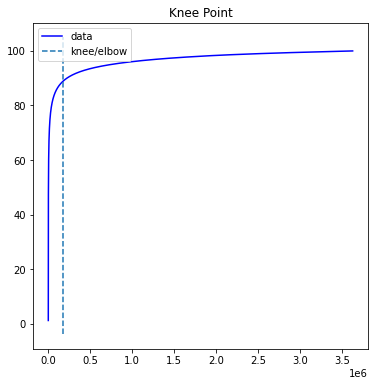

In [19]:
twogram_kneedle = KneeLocator(x=df_twogram_select.cumul_ratio.index, y=df_twogram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
twogram_kneedle.plot_knee()

In [20]:
knee_point_twogram = round(twogram_kneedle.knee_y)

In [21]:
df_twogram_knee = df_twogram_select[df_twogram_select.cumul_ratio <= knee_point_twogram]
df_twogram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_twogram_knee

<ipython-input-21-8da720a80491>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twogram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,twogram,frequency
0,i am,9310563
1,do not,8095395
2,it s,7436197
3,that s,4564126
4,you re,4355237
...,...,...
179482,creepy is,203
179483,load for,203
179484,and whipped,203
179485,is oskar,203


In [22]:
df_twogram_select2 = df_twogram_select.iloc[twogram_select_start:twogram_select_end,]
df_twogram_select2

,twogram,frequency,ratio,cumul_ratio
0,i am,9310563,1.255778,1.255778
1,do not,8095395,1.091880,2.347658
2,it s,7436197,1.002970,3.350627
3,that s,4564126,0.615594,3.966221
4,you re,4355237,0.587420,4.553641
...,...,...,...,...
9995,okay sir,6936,0.000936,68.921631
9996,hurry hurry,6935,0.000935,68.922566
9997,bad as,6933,0.000935,68.923501
9998,be glad,6932,0.000935,68.924436


In [23]:
df_twogram_knee.to_csv("Twogram_Selected.csv", index=False)
df_twogram_select2.to_excel(f"Twogram_Selected_{twogram_select_end}.xlsx", index=False)

In [24]:
if threegram_sentence_check:
    df_threegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Three_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_threegram_sent.rename(columns={"three_gram":"threegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_threegram = df_threegram_sent.loc[:,["threegram","frequency"]]
else:
    df_threegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Threegram_Merge.csv")  
    df_threegram = df_threegram.loc[:,["threegram","frequency"]]

df_threegram

,threegram,frequency
0,i do not,3246539
1,do not know,1606191
2,what are you,1324981
3,i am not,1120471
4,i am sorry,1103453
...,...,...
11617124,he s abby,6
11617125,if richard knows,6
11617126,he requested this,6
11617127,sound of opportunity,6


In [25]:
d_list3  = df_threegram.iloc[:,0].values.tolist()

resultlist3 = []
manager = multiprocessing.Manager()
resultlist3 = manager.list()

def wordgroup_with_words(d_list3):
    mergelist = []
    try:
        word = d_list3.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist3.append(d_list3)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list3) # string_word liste

result_list3 = list(resultlist3)
df_result3 = pd.DataFrame(result_list3, columns=[0])  # add columns parameter for empty result
df_result3 = df_result3.rename(columns = {0: "threegram"})
df_merge3 = pd.merge(df_result3, df_threegram, how="left", on="threegram")
df_merge_result3 = df_merge3.sort_values(by="frequency", ascending=False)
df_merge_result3.drop_duplicates(inplace=True)
df_merge_result3.reset_index(drop=True, inplace=True)
df_threegram_select = df_merge_result3
df_threegram_select

,threegram,frequency
0,i do not,3246539
1,do not know,1606191
2,what are you,1324981
3,i am not,1120471
4,i am sorry,1103453
...,...,...
10406366,recipe for something,6
10406367,not that irisa,6
10406368,rachel s betrayal,6
10406369,who either entered,6


In [26]:
threegram_frequency = df_threegram_select.iloc[:,1].sum()

In [27]:
df_threegram_select["ratio"] = round(((df_threegram_select.iloc[:,1]/threegram_frequency)*100),7)

In [28]:
df_threegram_select["cumul_ratio"] = np.cumsum(df_threegram_select["ratio"])

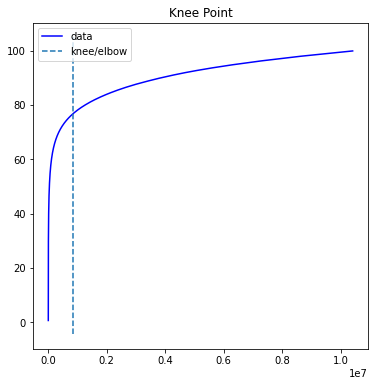

In [29]:
threegram_kneedle = KneeLocator(x=df_threegram_select.cumul_ratio.index, y=df_threegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
threegram_kneedle.plot_knee()

In [30]:
knee_point_threegram = round(threegram_kneedle.knee_y)

In [31]:
df_threegram_knee = df_threegram_select[df_threegram_select.cumul_ratio <= knee_point_threegram]
df_threegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_threegram_knee

<ipython-input-31-b241fb118b27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_threegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,threegram,frequency
0,i do not,3246539
1,do not know,1606191
2,what are you,1324981
3,i am not,1120471
4,i am sorry,1103453
...,...,...
871213,about you vi,48
871214,bien phu we,48
871215,every night that,48
871216,moved in daylight,48


In [32]:
df_threegram_select2 = df_threegram_select.iloc[threegram_select_start:threegram_select_end,]
df_threegram_select2

,threegram,frequency,ratio,cumul_ratio
0,i do not,3246539,0.616062,0.616062
1,do not know,1606191,0.304790,0.920852
2,what are you,1324981,0.251428,1.172280
3,i am not,1120471,0.212620,1.384900
4,i am sorry,1103453,0.209391,1.594290
...,...,...,...,...
9995,you hold on,4818,0.000914,38.039522
9996,one by one,4818,0.000914,38.040436
9997,you next week,4816,0.000914,38.041350
9998,want the truth,4816,0.000914,38.042264


In [33]:
df_threegram_knee.to_csv("Threegram_Selected.csv", index=False)
df_threegram_select2.to_excel(f"Threegram_Selected_{threegram_select_end}.xlsx", index=False)

In [34]:
if fourgram_sentence_check:
    df_fourgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Four_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_fourgram_sent.rename(columns={"four_gram":"fourgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_fourgram = df_fourgram_sent.loc[:,["fourgram","frequency"]]
else:
    df_fourgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Fourgram_Merge.csv")  
    df_fourgram = df_fourgram.loc[:,["fourgram","frequency"]]

df_fourgram

,fourgram,frequency
0,i do not know,1317934
1,what are you doing,665946
2,i do not want,310217
3,what s going on,298508
4,what do you mean,278296
...,...,...
15975654,freedom to stay after,6
15975655,i agree that no,6
15975656,to just be alive,6
15975657,this suite is usually,6


In [35]:
d_list4  = df_fourgram.iloc[:,0].values.tolist()

resultlist4 = []
manager = multiprocessing.Manager()
resultlist4 = manager.list()

def wordgroup_with_words(d_list4):
    mergelist = []
    try:
        word = d_list4.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist4.append(d_list4)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list4) # string_word liste

result_list4 = list(resultlist4)
df_result4 = pd.DataFrame(result_list4, columns=[0])  # add columns parameter for empty result
df_result4 = df_result4.rename(columns = {0: "fourgram"})
df_merge4 = pd.merge(df_result4, df_fourgram, how="left", on="fourgram")
df_merge_result4 = df_merge4.sort_values(by="frequency", ascending=False)
df_merge_result4.drop_duplicates(inplace=True)
df_merge_result4.reset_index(drop=True, inplace=True)
df_fourgram_select = df_merge_result4
df_fourgram_select

,fourgram,frequency
0,i do not know,1317934
1,what are you doing,665946
2,i do not want,310217
3,what s going on,298508
4,what do you mean,278296
...,...,...
14620121,to rent rooms and,6
14620122,how quick the hour,6
14620123,booger what s happenin,6
14620124,shame to know your,6


In [36]:
fourgram_frequency = df_fourgram_select.iloc[:,1].sum()

In [37]:
df_fourgram_select["ratio"] = round(((df_fourgram_select.iloc[:,1]/fourgram_frequency)*100),7)

In [38]:
df_fourgram_select["cumul_ratio"] = np.cumsum(df_fourgram_select["ratio"])

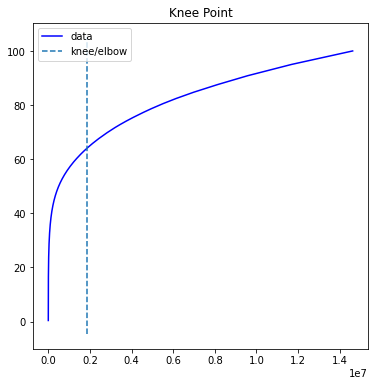

In [39]:
fourgram_kneedle = KneeLocator(x=df_fourgram_select.cumul_ratio.index, y=df_fourgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
fourgram_kneedle.plot_knee()

In [40]:
knee_point_fourgram = round(fourgram_kneedle.knee_y)

In [41]:
df_fourgram_knee = df_fourgram_select[df_fourgram_select.cumul_ratio <= knee_point_fourgram]
df_fourgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_fourgram_knee

<ipython-input-41-03ada6cfbf6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fourgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,fourgram,frequency
0,i do not know,1317934
1,what are you doing,665946
2,i do not want,310217
3,what s going on,298508
4,what do you mean,278296
...,...,...
1844830,surgically grafted to his,25
1844831,whatever snow does in,25
1844832,was plain to see,25
1844833,on that survival course,25


In [42]:
df_fourgram_select2 = df_fourgram_select.iloc[fourgram_select_start:fourgram_select_end,]
df_fourgram_select2

,fourgram,frequency,ratio,cumul_ratio
0,i do not know,1317934,0.371576,0.371576
1,what are you doing,665946,0.187755,0.559331
2,i do not want,310217,0.087462,0.646793
3,what s going on,298508,0.084161,0.730953
4,what do you mean,278296,0.078462,0.809416
...,...,...,...,...
9995,you can come in,2143,0.000604,20.055977
9996,you realize what you,2143,0.000604,20.056582
9997,so nice to see,2142,0.000604,20.057185
9998,how s that going,2142,0.000604,20.057789


In [44]:
df_fourgram_knee.to_csv("Fourgram_Selected.csv", index=False)
df_fourgram_select2.to_excel(f"Fourgram_Selected_{fourgram_select_end}.xlsx", index=False)

In [14]:
if fivegram_sentence_check:
    df_fivegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Five_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_fivegram_sent.rename(columns={"five_gram":"fivegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_fivegram = df_fivegram_sent.loc[:,["fivegram","frequency"]]
else:
    df_fivegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Fivegram_Merge.csv")  
    df_fivegram = df_fivegram.loc[:,["fivegram","frequency"]]

df_fivegram

,fivegram,frequency
0,i do not want to,182100
1,what are you doing here,167734
2,i do not know what,166508
3,what are you talking about,166083
4,i do not think so,97382
...,...,...
15287430,the center of your country,6
15287431,must go to work early,6
15287432,that same trouble in bed,6
15287433,that s why i wish,6


In [15]:
d_list5  = df_fivegram.iloc[:,0].values.tolist()

resultlist5 = []
manager = multiprocessing.Manager()
resultlist5 = manager.list()

def wordgroup_with_words(d_list5):
    mergelist = []
    try:
        word = d_list5.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist5.append(d_list5)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list5) # string_word liste

result_list5 = list(resultlist5)
df_result5 = pd.DataFrame(result_list5, columns=[0])  # add columns parameter for empty result
df_result5 = df_result5.rename(columns = {0: "fivegram"})
df_merge5 = pd.merge(df_result5, df_fivegram, how="left", on="fivegram")
df_merge_result5 = df_merge5.sort_values(by="frequency", ascending=False)
df_merge_result5.drop_duplicates(inplace=True)
df_merge_result5.reset_index(drop=True, inplace=True)
df_fivegram_select = df_merge_result5
df_fivegram_select

,fivegram,frequency
0,i do not want to,182100
1,what are you doing here,167734
2,i do not know what,166508
3,what are you talking about,166083
4,i do not think so,97382
...,...,...
13984425,picked him up in hilton,6
13984426,will get away this time,6
13984427,the hearing s starting any,6
13984428,so it could be your,6


In [16]:
fivegram_frequency = df_fivegram_select.iloc[:,1].sum()

In [17]:
df_fivegram_select["ratio"] = round(((df_fivegram_select.iloc[:,1]/fivegram_frequency)*100),7)

In [18]:
df_fivegram_select["cumul_ratio"] = np.cumsum(df_fivegram_select["ratio"])

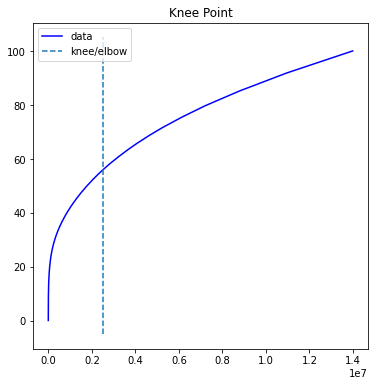

In [19]:
fivegram_kneedle = KneeLocator(x=df_fivegram_select.cumul_ratio.index, y=df_fivegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
fivegram_kneedle.plot_knee()

In [20]:
knee_point_fivegram = round(fivegram_kneedle.knee_y)

In [21]:
df_fivegram_knee = df_fivegram_select[df_fivegram_select.cumul_ratio <= knee_point_fivegram]
df_fivegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_fivegram_knee

<ipython-input-21-aa6ae317da90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fivegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,fivegram,frequency
0,i do not want to,182100
1,what are you doing here,167734
2,i do not know what,166508
3,what are you talking about,166083
4,i do not think so,97382
...,...,...
2510517,re about to be lunch,17
2510518,kittredge is not for you,17
2510519,how about other than ralph,17
2510520,he s more than qualified,17


In [22]:
df_fivegram_select2 = df_fivegram_select.iloc[fivegram_select_start:fivegram_select_end,]
df_fivegram_select2

,fivegram,frequency,ratio,cumul_ratio
0,i do not want to,182100,0.080633,0.080633
1,what are you doing here,167734,0.074271,0.154904
2,i do not know what,166508,0.073729,0.228633
3,what are you talking about,166083,0.073540,0.302173
4,i do not think so,97382,0.043120,0.345293
...,...,...,...,...
9995,shut up shut up shut,862,0.000382,11.498238
9996,we were waiting for you,862,0.000382,11.498620
9997,have you got to say,862,0.000382,11.499001
9998,what s your last name,862,0.000382,11.499383


In [23]:
df_fivegram_knee.to_csv("Fivegram_Selected.csv", index=False)
df_fivegram_select2.to_excel(f"Fivegram_Selected_{fivegram_select_end}.xlsx", index=False)

In [14]:
if sixgram_sentence_check:
    df_sixgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Six_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_sixgram_sent.rename(columns={"six_gram":"sixgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_sixgram = df_sixgram_sent.loc[:,["sixgram","frequency"]]
else:
    df_sixgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Sixgram_Merge.csv")  
    df_sixgram = df_sixgram.loc[:,["sixgram","frequency"]]

df_sixgram = df_sixgram[df_sixgram["frequency"] > 5]
df_sixgram

,sixgram,frequency
0,i do not know what to,43489
1,what the hell are you doing,43421
2,i do not know what you,41846
3,do not know what you re,39759
4,let s get out of here,36588
...,...,...
11652916,am desperately in need of a,6
11652917,am gonna take her to miniature,6
11652918,some of these up for you,6
11652919,some of these trees at 9000,6


In [15]:
d_list6  = df_sixgram.iloc[:,0].values.tolist()

resultlist6 = []
manager = multiprocessing.Manager()
resultlist6 = manager.list()

def wordgroup_with_words(d_list6):
    mergelist = []
    try:
        word = d_list6.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist6.append(d_list6)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list6) # string_word liste

result_list6 = list(resultlist6)
df_result6 = pd.DataFrame(result_list6, columns=[0])  # add columns parameter for empty result
df_result6 = df_result6.rename(columns = {0: "sixgram"})
df_merge6 = pd.merge(df_result6, df_sixgram, how="left", on="sixgram")
df_merge_result6 = df_merge6.sort_values(by="frequency", ascending=False)
df_merge_result6.drop_duplicates(inplace=True)
df_merge_result6.reset_index(drop=True, inplace=True)
df_sixgram_select = df_merge_result6
df_sixgram_select

,sixgram,frequency
0,i do not know what to,43489
1,what the hell are you doing,43421
2,i do not know what you,41846
3,do not know what you re,39759
4,let s get out of here,36588
...,...,...
10558517,yeah we all agreed it was,6
10558518,thing is we now have hope,6
10558519,it makes no sense that she,6
10558520,i found out what s really,6


In [16]:
sixgram_frequency = df_sixgram_select.iloc[:,1].sum()

In [17]:
df_sixgram_select["ratio"] = round(((df_sixgram_select.iloc[:,1]/sixgram_frequency)*100),7)

In [18]:
df_sixgram_select["cumul_ratio"] = np.cumsum(df_sixgram_select["ratio"])

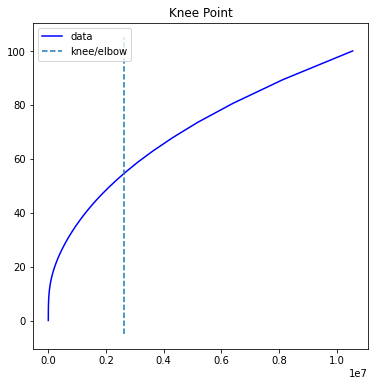

In [19]:
sixgram_kneedle = KneeLocator(x=df_sixgram_select.cumul_ratio.index, y=df_sixgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
sixgram_kneedle.plot_knee()

In [20]:
knee_point_sixgram = round(sixgram_kneedle.knee_y)

In [21]:
df_sixgram_knee = df_sixgram_select[df_sixgram_select.cumul_ratio <= knee_point_sixgram]
df_sixgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_sixgram_knee

<ipython-input-21-6f56fa6aca9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sixgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,sixgram,frequency
0,i do not know what to,43489
1,what the hell are you doing,43421
2,i do not know what you,41846
3,do not know what you re,39759
4,let s get out of here,36588
...,...,...
2671673,am here well i can not,12
2671674,it s a model like an,12
2671675,we d be interested to see,12
2671676,you got yourself into those cuffs,12


In [22]:
df_sixgram_select2 = df_sixgram_select.iloc[sixgram_select_start:sixgram_select_end,]
df_sixgram_select2

,sixgram,frequency,ratio,cumul_ratio
0,i do not know what to,43489,0.031731,0.031731
1,what the hell are you doing,43421,0.031682,0.063413
2,i do not know what you,41846,0.030532,0.093945
3,do not know what you re,39759,0.029010,0.122954
4,let s get out of here,36588,0.026696,0.149650
...,...,...,...,...
9995,s nothing to do with you,347,0.000253,7.253181
9996,do you think we re doing,347,0.000253,7.253434
9997,that s the last of them,347,0.000253,7.253687
9998,i will do what i have,347,0.000253,7.253941


In [23]:
df_sixgram_knee.to_csv("Sixgram_Selected.csv", index=False)
df_sixgram_select2.to_excel(f"Sixgram_Selected_{sixgram_select_end}.xlsx", index=False)

In [24]:
if sevengram_sentence_check:
    df_sevengram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Seven_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_sevengram_sent.rename(columns={"seven_gram":"sevengram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_sevengram = df_sevengram_sent.loc[:,["sevengram","frequency"]]
else:
    df_sevengram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Sevengram_Merge.csv")  
    df_sevengram = df_sevengram.loc[:,["sevengram","frequency"]]

df_sevengram = df_sevengram[df_sevengram["frequency"] > 5]
df_sevengram

,sevengram,frequency
0,do not know what you re talking,28672
1,i do not know what you re,28558
2,not know what you re talking about,28517
3,what do you want me to do,24163
4,i do not know what to do,17944
...,...,...
7569606,one of the horses that lives at,6
7569607,think that i would kill for that,6
7569608,i assume you re not leaving without,6
7569609,the controls until new chips are installed,6


In [25]:
d_list7  = df_sevengram.iloc[:,0].values.tolist()

resultlist7 = []
manager = multiprocessing.Manager()
resultlist7 = manager.list()

def wordgroup_with_words(d_list7):
    mergelist = []
    try:
        word = d_list7.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist7.append(d_list7)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list7) # string_word liste

result_list7 = list(resultlist7)
df_result7 = pd.DataFrame(result_list7, columns=[0])  # add columns parameter for empty result
df_result7 = df_result7.rename(columns = {0: "sevengram"})
df_merge7 = pd.merge(df_result7, df_sevengram, how="left", on="sevengram")
df_merge_result7 = df_merge7.sort_values(by="frequency", ascending=False)
df_merge_result7.drop_duplicates(inplace=True)
df_merge_result7.reset_index(drop=True, inplace=True)
df_sevengram_select = df_merge_result7
df_sevengram_select

,sevengram,frequency
0,do not know what you re talking,28672
1,i do not know what you re,28558
2,not know what you re talking about,28517
3,what do you want me to do,24163
4,i do not know what to do,17944
...,...,...
6765151,not but good luck with your things,6
6765152,who has not been dragged by his,6
6765153,have got my guardian angel working overtime,6
6765154,were not actually men they were flies,6


In [26]:
sevengram_frequency = df_sevengram_select.iloc[:,1].sum()

In [27]:
df_sevengram_select["ratio"] = round(((df_sevengram_select.iloc[:,1]/sevengram_frequency)*100),7)

In [28]:
df_sevengram_select["cumul_ratio"] = np.cumsum(df_sevengram_select["ratio"])

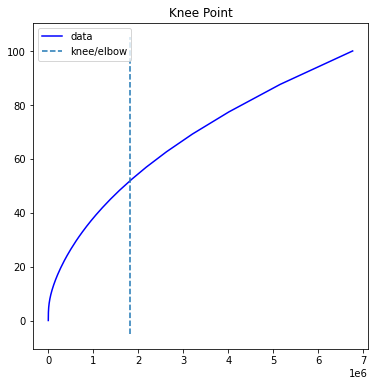

In [29]:
sevengram_kneedle = KneeLocator(x=df_sevengram_select.cumul_ratio.index, y=df_sevengram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
sevengram_kneedle.plot_knee()

In [30]:
knee_point_sevengram = round(sevengram_kneedle.knee_y)

In [31]:
df_sevengram_knee = df_sevengram_select[df_sevengram_select.cumul_ratio <= knee_point_sevengram]
df_sevengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_sevengram_knee

<ipython-input-31-c7523e0bfd65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sevengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,sevengram,frequency
0,do not know what you re talking,28672
1,i do not know what you re,28558
2,not know what you re talking about,28517
3,what do you want me to do,24163
4,i do not know what to do,17944
...,...,...
1823499,a doctor will see you in mcmurdo,11
1823500,said that we could never never ever,11
1823501,d have to do is read it,11
1823502,you know what i hope you re,11


In [32]:
df_sevengram_select2 = df_sevengram_select.iloc[sevengram_select_start:sevengram_select_end,]
df_sevengram_select2

,sevengram,frequency,ratio,cumul_ratio
0,do not know what you re talking,28672,0.036676,0.036676
1,i do not know what you re,28558,0.036530,0.073206
2,not know what you re talking about,28517,0.036478,0.109684
3,what do you want me to do,24163,0.030908,0.140592
4,i do not know what to do,17944,0.022953,0.163545
...,...,...,...,...
9995,i am so glad to meet you,142,0.000182,5.059881
9996,and there is nothing you can do,142,0.000182,5.060062
9997,if it s the last thing i,142,0.000182,5.060244
9998,i just wanted to talk to him,142,0.000182,5.060425


In [33]:
df_sevengram_knee.to_csv("Sevengram_Selected.csv", index=False)
df_sevengram_select2.to_excel(f"Sevengram_Selected_{sevengram_select_end}.xlsx", index=False)

In [34]:
if eightgram_sentence_check:
    df_eightgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Eight_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_eightgram_sent.rename(columns={"eight_gram":"eightgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_eightgram = df_eightgram_sent.loc[:,["eightgram","frequency"]]
else:
    df_eightgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Eightgram_Merge.csv")  
    df_eightgram = df_eightgram.loc[:,["eightgram","frequency"]]

df_eightgram = df_eightgram[df_eightgram["frequency"] >= 5]
df_eightgram

,eightgram,frequency
0,do not know what you re talking about,28456
1,i do not know what you re talking,23718
2,i do not want to talk about it,6782
3,have no idea what you re talking about,5211
4,can i talk to you for a second,4847
...,...,...
4243598,s not gonna show you how it s,6
4243599,never have i been so happy to be,6
4243600,i do not need no fucking hug from,6
4243601,do not give her the weight room thing,6


In [35]:
d_list8  = df_eightgram.iloc[:,0].values.tolist()

resultlist8 = []
manager = multiprocessing.Manager()
resultlist8 = manager.list()

def wordgroup_with_words(d_list8):
    mergelist = []
    try:
        word = d_list8.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist8.append(d_list8)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list8) # string_word liste

result_list8 = list(resultlist8)
df_result8 = pd.DataFrame(result_list8, columns=[0])  # add columns parameter for empty result
df_result8 = df_result8.rename(columns = {0: "eightgram"})
df_merge8 = pd.merge(df_result8, df_eightgram, how="left", on="eightgram")
df_merge_result8 = df_merge8.sort_values(by="frequency", ascending=False)
df_merge_result8.drop_duplicates(inplace=True)
df_merge_result8.reset_index(drop=True, inplace=True)
df_eightgram_select = df_merge_result8
df_eightgram_select

,eightgram,frequency
0,do not know what you re talking about,28456
1,i do not know what you re talking,23718
2,i do not want to talk about it,6782
3,have no idea what you re talking about,5211
4,can i talk to you for a second,4847
...,...,...
3731168,know that i am overly protective of you,6
3731169,remember a case a couple years back doris,6
3731170,you spent half the meal staring out the,6
3731171,lloyd loves vermont and i have always loved,6


In [36]:
eightgram_frequency = df_eightgram_select.iloc[:,1].sum()

In [37]:
df_eightgram_select["ratio"] = round(((df_eightgram_select.iloc[:,1]/eightgram_frequency)*100),7)

In [38]:
df_eightgram_select["cumul_ratio"] = np.cumsum(df_eightgram_select["ratio"])

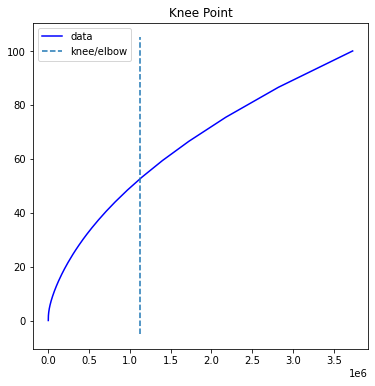

In [39]:
eightgram_kneedle = KneeLocator(x=df_eightgram_select.cumul_ratio.index, y=df_eightgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
eightgram_kneedle.plot_knee()

In [40]:
knee_point_eightgram = round(eightgram_kneedle.knee_y)

In [41]:
df_eightgram_knee = df_eightgram_select[df_eightgram_select.cumul_ratio <= knee_point_eightgram]
df_eightgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_eightgram_knee

<ipython-input-41-a0aa4204db9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eightgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,eightgram,frequency
0,do not know what you re talking about,28456
1,i do not know what you re talking,23718
2,i do not want to talk about it,6782
3,have no idea what you re talking about,5211
4,can i talk to you for a second,4847
...,...,...
1139335,the grass it s not even green it,10
1139336,confusion memory loss complete or partial loss of,10
1139337,forget about all that shit this was your,10
1139338,kubrick s next film would prove even more,10


In [42]:
df_eightgram_select2 = df_eightgram_select.iloc[eightgram_select_start:eightgram_select_end,]
df_eightgram_select2

,eightgram,frequency,ratio,cumul_ratio
0,do not know what you re talking about,28456,0.070270,0.070270
1,i do not know what you re talking,23718,0.058570,0.128840
2,i do not want to talk about it,6782,0.016748,0.145587
3,have no idea what you re talking about,5211,0.012868,0.158455
4,can i talk to you for a second,4847,0.011969,0.170425
...,...,...,...,...
9995,we spent months uncovering them and accumulati...,73,0.000180,4.098306
9996,thought we had another bite at the apple,73,0.000180,4.098487
9997,it s like looking for a needle in,73,0.000180,4.098667
9998,and you knew it was the right thing,73,0.000180,4.098847


In [43]:
df_eightgram_knee.to_csv("Eightgram_Selected.csv", index=False)
df_eightgram_select2.to_excel(f"Eightgram_Selected_{eightgram_select_end}.xlsx", index=False)

In [44]:
if ninegram_sentence_check:
    df_ninegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Nine_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_ninegram_sent.rename(columns={"nine_gram":"ninegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_ninegram = df_ninegram_sent.loc[:,["ninegram","frequency"]]
else:
    df_ninegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Ninegram_Merge.csv")  
    df_ninegram = df_ninegram.loc[:,["ninegram","frequency"]]

df_ninegram = df_ninegram[df_ninegram["frequency"] >= 5]
df_ninegram

,ninegram,frequency
0,i do not know what you re talking about,23532
1,i have no idea what you re talking about,4429
2,you do not know what you re talking about,3511
3,what the hell do you think you re doing,3150
4,i do not think that s a good idea,2889
...,...,...
1955815,how long did they give you to make it,6
1955816,must be the one with the john ford obsession,6
1955817,s the wild bunch on the back of him,6
1955818,is that the part i am supposed to get,6


In [45]:
d_list9  = df_ninegram.iloc[:,0].values.tolist()

resultlist9 = []
manager = multiprocessing.Manager()
resultlist9 = manager.list()

def wordgroup_with_words(d_list9):
    mergelist = []
    try:
        word = d_list9.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist9.append(d_list9)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list9) # string_word liste

result_list9 = list(resultlist9)
df_result9 = pd.DataFrame(result_list9, columns=[0])  # add columns parameter for empty result
df_result9 = df_result9.rename(columns = {0: "ninegram"})
df_merge9 = pd.merge(df_result9, df_ninegram, how="left", on="ninegram")
df_merge_result9 = df_merge9.sort_values(by="frequency", ascending=False)
df_merge_result9.drop_duplicates(inplace=True)
df_merge_result9.reset_index(drop=True, inplace=True)
df_ninegram_select = df_merge_result9
df_ninegram_select

,ninegram,frequency
0,i do not know what you re talking about,23532
1,i have no idea what you re talking about,4429
2,you do not know what you re talking about,3511
3,what the hell do you think you re doing,3150
4,i do not think that s a good idea,2889
...,...,...
1683893,i can tell you that farm has been abandoned,6
1683894,you must keep your demands within reasonable l...,6
1683895,i knew you d not leave me and go,6
1683896,apparently if my gut tells me i am in,6


In [46]:
ninegram_frequency = df_ninegram_select.iloc[:,1].sum()

In [47]:
df_ninegram_select["ratio"] = round(((df_ninegram_select.iloc[:,1]/ninegram_frequency)*100),7)

In [48]:
df_ninegram_select["cumul_ratio"] = np.cumsum(df_ninegram_select["ratio"])

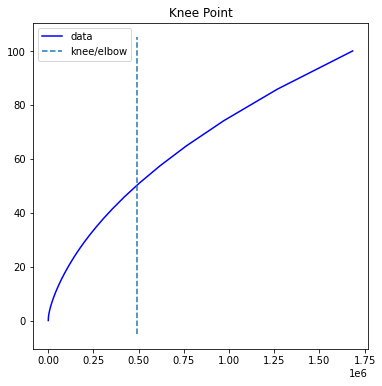

In [49]:
ninegram_kneedle = KneeLocator(x=df_ninegram_select.cumul_ratio.index, y=df_ninegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
ninegram_kneedle.plot_knee()

In [50]:
knee_point_ninegram = round(ninegram_kneedle.knee_y)

In [51]:
df_ninegram_knee = df_ninegram_select[df_ninegram_select.cumul_ratio <= knee_point_ninegram]
df_ninegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_ninegram_knee

<ipython-input-51-b7edd7138548>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ninegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,ninegram,frequency
0,i do not know what you re talking about,23532
1,i have no idea what you re talking about,4429
2,you do not know what you re talking about,3511
3,what the hell do you think you re doing,3150
4,i do not think that s a good idea,2889
...,...,...
486141,she may be facilitating a terrorist attack on ...,11
486142,need to put a baby in that woman yesterday,11
486143,you ever been sodomized or anything like that ...,11
486144,no they re just doodles you know immature crap,11


In [52]:
df_ninegram_select2 = df_ninegram_select.iloc[ninegram_select_start:ninegram_select_end,]
df_ninegram_select2

,ninegram,frequency,ratio,cumul_ratio
0,i do not know what you re talking about,23532,0.133239,0.133239
1,i have no idea what you re talking about,4429,0.025077,0.158316
2,you do not know what you re talking about,3511,0.019879,0.178196
3,what the hell do you think you re doing,3150,0.017835,0.196031
4,i do not think that s a good idea,2889,0.016358,0.212389
...,...,...,...,...
9995,i am just trying to do my job man,45,0.000255,4.602796
9996,this is not the end it is the beginning,45,0.000255,4.603050
9997,everyone s a winner we re makin our fame,45,0.000255,4.603305
9998,but i am surprised you let him bring her,45,0.000255,4.603560


In [53]:
df_ninegram_knee.to_csv("Ninegram_Selected.csv", index=False)
df_ninegram_select2.to_excel(f"Ninegram_Selected_{ninegram_select_end}.xlsx", index=False)

In [54]:
if tengram_sentence_check:
    df_tengram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Ten_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_tengram_sent.rename(columns={"ten_gram":"tengram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_tengram = df_tengram_sent.loc[:,["tengram","frequency"]]
else:
    df_tengram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Tengram_Merge.csv")  
    df_tengram = df_tengram.loc[:,["tengram","frequency"]]

#df_tengram = df_tengram[df_ninegram["frequency"] > 5]
df_tengram

,tengram,frequency
0,our father who art in heaven hallowed be thy name,3630
1,ten nine eight seven six five four three two one,1772
2,one two three four five six seven eight nine ten,1632
3,hail mary full of grace the lord is with thee,1438
4,captioned by media access group at wgbh access...,1428
...,...,...
611523,like he s ever gonna look at these books,6
611524,listen this is what s gonna happen all right,6
611525,like i am gonna make money on a fire,6
611526,i gotta fire her so you do not feel weird,6


In [55]:
d_list10  = df_tengram.iloc[:,0].values.tolist()

resultlist10 = []
manager = multiprocessing.Manager()
resultlist10 = manager.list()

def wordgroup_with_words(d_list10):
    mergelist = []
    try:
        word = d_list10.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist10.append(d_list10)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list10) # string_word liste

result_list10 = list(resultlist10)
df_result10 = pd.DataFrame(result_list10, columns=[0])  # add columns parameter for empty result
df_result10 = df_result10.rename(columns = {0: "tengram"})
df_merge10 = pd.merge(df_result10, df_tengram, how="left", on="tengram")
df_merge_result10 = df_merge10.sort_values(by="frequency", ascending=False)
df_merge_result10.drop_duplicates(inplace=True)
df_merge_result10.reset_index(drop=True, inplace=True)
df_tengram_select = df_merge_result10
df_tengram_select

,tengram,frequency
0,our father who art in heaven hallowed be thy name,3630
1,ten nine eight seven six five four three two one,1772
2,one two three four five six seven eight nine ten,1632
3,hail mary full of grace the lord is with thee,1438
4,captioned by media access group at wgbh access...,1428
...,...,...
505323,she always watches those home movies with you ...,12
505324,why did not you tell me john was coming back,12
505325,he came straight to this house to claim his share,12
505326,i will have to teach you a few things too,12


In [56]:
tengram_frequency = df_tengram_select.iloc[:,1].sum()

In [57]:
df_tengram_select["ratio"] = round(((df_tengram_select.iloc[:,1]/tengram_frequency)*100),7)

In [58]:
df_tengram_select["cumul_ratio"] = np.cumsum(df_tengram_select["ratio"])

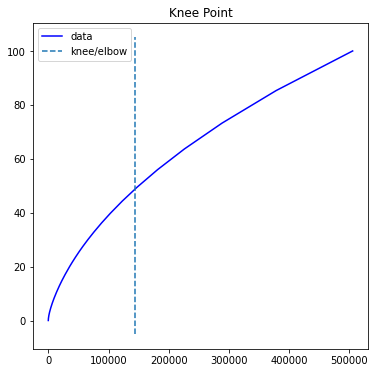

In [59]:
tengram_kneedle = KneeLocator(x=df_tengram_select.cumul_ratio.index, y=df_tengram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
tengram_kneedle.plot_knee()

In [60]:
knee_point_tengram = round(tengram_kneedle.knee_y)

In [61]:
df_tengram_knee = df_tengram_select[df_tengram_select.cumul_ratio <= knee_point_tengram]
df_tengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_tengram_knee

<ipython-input-61-609ab78376ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,tengram,frequency
0,our father who art in heaven hallowed be thy name,3630
1,ten nine eight seven six five four three two one,1772
2,one two three four five six seven eight nine ten,1632
3,hail mary full of grace the lord is with thee,1438
4,captioned by media access group at wgbh access...,1428
...,...,...
144967,you have no idea what your son is going through,20
144968,you worked side by side with adrian chase for ...,20
144969,we re all just trying to do our jobs here,20
144970,the army took the beach from which he had fled,20


In [62]:
df_tengram_select2 = df_tengram_select.iloc[tengram_select_start:tengram_select_end,]
df_tengram_select2

,tengram,frequency,ratio,cumul_ratio
0,our father who art in heaven hallowed be thy name,3630,0.034984,0.034984
1,ten nine eight seven six five four three two one,1772,0.017078,0.052062
2,one two three four five six seven eight nine ten,1632,0.015728,0.067790
3,hail mary full of grace the lord is with thee,1438,0.013859,0.081649
4,captioned by media access group at wgbh access...,1428,0.013762,0.095411
...,...,...,...,...
9995,you see professor slughorn possesses something...,60,0.000578,8.530009
9996,all it would require is for you to help us,60,0.000578,8.530587
9997,you take the weekend to think about it mr simms,60,0.000578,8.531165
9998,perhaps you d like to share it with your wife,60,0.000578,8.531743


In [63]:
df_tengram_knee.to_csv("Tengram_Selected.csv", index=False)
df_tengram_select2.to_excel(f"Tengram_Selected_{tengram_select_end}.xlsx", index=False)

#### Copy Move And Delete

In [64]:
output_file = glob.glob(f"*_Selected*")
output_file

['Sixgram_Selected.csv',
 'Sixgram_Selected_10000.xlsx',
 'Sevengram_Selected.csv',
 'Sevengram_Selected_10000.xlsx',
 'Eightgram_Selected.csv',
 'Eightgram_Selected_10000.xlsx',
 'Ninegram_Selected.csv',
 'Ninegram_Selected_10000.xlsx',
 'Tengram_Selected.csv',
 'Tengram_Selected_10000.xlsx']

In [65]:
for l in output_file:
    source = l # source directory
    destination = path
    shutil.copy2(source, destination)

In [66]:
for j in output_file:
    try:
        os.remove(j)
    except:
        pass